# PyRoss Stochastic TSI testing

We test here the stochastic simulation of TSI-SIR from "pyross/tsi/stochastic.pyx".

The method used in a Monte-Carlo tau-leaping algorithm that uses binomial distributions rather than classic Poisson distributions.


In [1]:
### Imports ###
import pyross.tsi as pyrosstsi
import numpy as np
import matplotlib.pyplot as plt

import time

### Run stochastic (MC) binomial $\tau$-leaping

We only use *one* age class to begin.

#### Parameters

- Population: $N=10^{3}$
- Number of age group = 1
- Time since infection *cut-off*: $\mathrm{tsi}_{\mathrm{max}} = 50$ days
- $\mathrm{d}\mathrm{tsi} = 1/5$ days
- Total length of the run: $T_{f} = 200$ days

We use: 
- $\beta(\tau) = \beta_{0}$
  with $\beta_{0} = 0.2$
- $\gamma(\tau) = \frac{\gamma_{0}}{\left( 1-e^{-\gamma_{0}(\tau_{\mathrm{max}}-\tau)} \right)}$, with $\gamma_{0} = 1/10. \, \mathrm{days}^{-1}$ and $\tau_{\mathrm{max}} = 50$ days.

  This function $\gamma(\tau)$ comes from a distribution of "residence time" in $I$ that is a truncated exponential. One should recover the regular Markovian SIR for $\tau_{\mathrm{max}} \to \infty$.

In [15]:
### Model Init from SIR class ###

# Population
N = int(1e3) # full population size
M = 1 # just one age group to begin
Ni = np.array([N]) # Array of age group sizes

# Contact Matrix
CM = np.zeros((M, M))
def contactMatrix(t):
    CM[0,0] = 1
    return CM

# Time since infection: cut-off + discretisation
tsi_max = 50 # days
dtsi = 1/5. # days
KI = int(tsi_max/dtsi)+1

# beta
def beta_fun(tsi, beta0, tsi_max):
    if tsi<tsi_max:
        return beta0
    else:
        return None
    
def beta_vec(beta0, KI, tsi_max):
    beta = []
    dtsi = tsi_max/float(KI)
    for k in range(KI):
        beta.append(beta_fun(k*dtsi, beta0, tsi_max))
    return beta

beta0 = 0.2
beta = np.zeros((M,KI))
for i in range(M):
    beta[i,:] = beta_vec(beta0, KI, tsi_max)

# gamma(tsi):
def gamma_fun(tsi, g0, tsi_max):
    if g0>0:
        if tsi<tsi_max:
            return g0/(1-np.exp(-g0*(tsi_max-tsi))) # truncated exponential
        else:
            return None
    else:
        return 0

def gamma_vec(g0, KI, tsi_max):
    gI = []
    dtsi = tsi_max/float(KI)
    for k in range(KI):
        gI.append(gamma_fun(dtsi*k, g0, tsi_max))
    return gI
    
g0 = 1/10. # day^{-1}
gamma = np.zeros((M,KI))
for i in range(M):    
    gamma[i,:] = gamma_vec(g0, KI, tsi_max)

# Sort parameters into a dictionary
parameters = {'beta': beta,
              'gI': gamma,
              'KI': KI}

# Finally, instantiate the model
model = pyrosstsi.stochastic.SIR(parameters, M, Ni)

print(r'Parameters are: beta0={} (beta constant), g0={} days^-1 (truncated exponential survival prob)'.format(beta0, g0))

Parameters are: beta0=0.2 (beta constant), g0=0.1 days^-1 (truncated exponential survival prob)


In [3]:
### Initial Conditions ###

# 4 infectives at t=0
I0 = np.zeros((M, KI))
I0_init_list = [(1, 0), (2, tsi_max/10.) ,(1, tsi_max/2.)] # (number of infectives, tsi)
for tup in I0_init_list:
    k = int(tup[1]/dtsi)
    I0[0,k] = tup[0]

# N-4 susceptibles at t=0
S0 = np.zeros(M)
S0[0] = N - np.sum(I0[0,:]) # 

In [4]:
### time step and total duration ###
dt = dtsi
Tf = 200 # days
Nf = int(Tf/dt)+1

In [5]:
### Seed (random generator) ###
seed0 = -1 # not the same seed at each run !

### RUN simulation ###
t1 = time.time()
data = model.simulate(S0, I0, contactMatrix, Tf, Nf, supplied_seed=seed0)
S_traj = data['S']
I_traj = data['I']

t2 = time.time()
# Let's print the time it took to run:
print('Time to run [#(time steps)={}, #(tsi compartments)={}]: {:1.3f} s'.format(Nf, KI, t2-t1))

Time to run [#(time steps)=1001, #(tsi compartments)=251]: 2.231 s


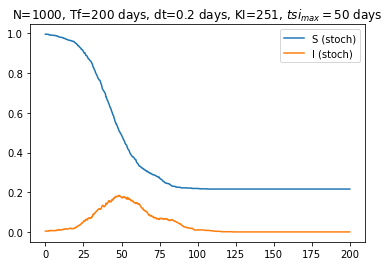

In [6]:
### PLOTS ###
t_list = np.linspace(0,Tf, Nf)

Sagg_traj = []
Iagg_traj = []
for t in range(Nf):
    Sagg_traj.append(np.sum(S_traj[t])/float(N))
    Iagg_traj.append(np.sum(I_traj[t])/float(N))

plt.plot(t_list, Sagg_traj, label='S (stoch)')
plt.plot(t_list, Iagg_traj, label='I (stoch)')
plt.legend()

plt.title('N={}, Tf={} days, dt={} days, KI={}, $tsi_{{max}}={} $ days'.format(N, Tf, dt, KI, tsi_max));

### Comparison to deterministic TSI-SIR model

We compare the average trajectory from stochastic simulation to the deterministic solution.
This is done with *no* age structure.

#### Deterministic dynamics
We give here the functions to run the deterministic dynamics

In [7]:
def lbda_trapezoidal(i, beta, KI, tsi_max):
    """
    Function to compute lambda, the rate to be infected per susceptibles
    A trapezoidal integrator is used to compute the integral.
    
    Parameters
    ----------
    i: np.array(KI)
       Infected population
    beta: np.array(KI)
       Infectiousness
    dtsi: float 
       the time since infection step (tsi discretisation)
    KI: int
       Number of discretisation points for tsi
       
    Returns
    -------
    lbda: float
    """
    dtsi = tsi_max/float(KI)
    lbda_array = [0.5*(beta[k]*i[k] + beta[k+1]*i[k+1])*dtsi for k in range(KI-1)]
    lbda = np.sum(lbda_array)
#     lbda = 0.5*beta[0]*i[0]*dtsi
#     for k in range(1, KI-1):
#         lbda += beta[k]*i[k]*dtsi
#     lbda += 0.5*beta[KI-1]*i[KI-1]*dtsi
    return lbda

def deterministic_step(s, i, beta, gamma, KI, tsi_max):
    """
    Function to go one step forward using the deterministic integrator.
    We use a RK2/Crank-Nicolson finite difference scheme
    
    Parameters
    ----------
    s: float
       Number of susceptibles
    i: np.array(KI, dtype=float)
       Infected population
    beta: np.array(KI)
       Infectiousness
    gamma: np.randge(K))
       Recovery rate with respect to tsi  
    dtsi: float 
       the time since infection step (tsi discretisation)
    KI: int
       Number of discretisation points for tsi
   
    Returns
    -------
    snext: float
       Updated number of susceptibles
    inext: np.array(KI, dtype=float)
       Updated infected population
    """

    i_p = np.zeros(KI)
    didt_p = np.zeros(KI-1)
    didt_c = np.zeros(KI-1)
    inext = np.zeros(KI)
    
    dtsi = tsi_max/float(KI)
    dt = dtsi
   
    # 1. Explicit time step
    lbda = lbda_trapezoidal(i, beta, KI, tsi_max)
    dsdt_p = - s * lbda 
    s_p = s + dsdt_p * dt
    i_p[0] = - dsdt_p
    for k in range(1,KI): # Advection
        i_p[k] = i[k-1]
    for k in range(1, KI): # Recovery
        didt_p[k-1] = - gamma[k] * i_p[k] 
        i_p[k] = i_p[k] + didt_p[k-1]*dt

    # 2. Correction 
    lbda_p = lbda_trapezoidal(i_p, beta, KI, tsi_max)
    dsdt_c = - s_p * lbda_p
    
    snext = s + 0.5*dt*(dsdt_p + dsdt_c)
    
    inext[0] = - 0.5*(dsdt_c + dsdt_p)
    for k in range(1, KI): # Advection
        inext[k] = i[k-1] 
    for k in range(1,KI):  # Recovery
        didt_c[k-1] = - gamma[k] * i_p[k]
        inext[k] = inext[k] + 0.5*dt*(didt_p[k-1] + didt_c[k-1])
    
    return snext, inext

def simulate_deterministic(s0, i0, beta, gamma, KI, tsi_max, Tf):
    dtsi = tsi_max/float(KI-1)
    Nf = int(Tf/dtsi)
    s_traj = np.zeros(Nf)
    i_traj = np.zeros((Nf, KI))

    # Initialise:
    s_traj[0] = s0
    i_traj[0] = i0

    # Run:
    for t in range(1,Nf):
        s_traj[t], i_traj[t] = deterministic_step(s_traj[t-1], i_traj[t-1], beta, gamma, KI, tsi_max)

    return s_traj, i_traj

#### Run deterministic

In [8]:
### Parameters ###
dtsi = 1/10.
KI = int(np.round(tsi_max/dtsi)) + 1 # We keep of course the same tsi_max

# beta
beta = beta_vec(beta0, KI, tsi_max)

# gamma
gI = gamma_vec(g0, KI, tsi_max)

### Initial condition ###
# We just rescale the initial condition from stochastic
i0 = np.zeros(KI)
for tup in I0_init_list:
    k = int(tup[1]/dtsi)
    i0[k] = (tup[0]/float(N))/dtsi

s0 = S0[0]/float(N)

### Run ###
s_det_traj, i_det_traj = simulate_deterministic(s0, i0, beta, gI, KI, tsi_max, Tf)

# ### Old code ###
# s_detold_traj, i_detold_traj = old.run_deterministic(s0, i0, beta, gI, dtsi, KI, int(np.round(Tf/dtsi)))

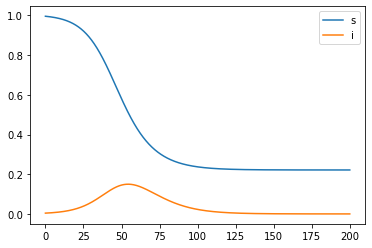

In [9]:
### PLOT ###
times = np.linspace(0, Tf, len(s_det_traj))
iagg_det_traj = []
# iagg_detold_traj = []
# aggregated infected pop
for t in range(len(s_det_traj)):
    iagg_det_traj.append(np.sum(i_det_traj[t]*dtsi))
#     iagg_detold_traj.append(np.sum(i_detold_traj[t])*dtsi)
    
plt.plot(times, s_det_traj, label='s')
# plt.plot(times, s_detold_traj, label='s old')
plt.plot(times, iagg_det_traj, label='i')
# plt.plot(times, iagg_detold_traj, label='i old')
plt.legend()

In [10]:
### Seed (random generator) ###
seed0 = -1 # not the same seed at each run !

### RUN simulation ###
total_runs = int(1e2)
data_agg_list = []
t1 = time.time()
for run in range(total_runs):
    data = model.simulate(S0, I0, contactMatrix, Tf, Nf, supplied_seed=seed0)
    S_list = data['S']
    I_list = data['I']
    Sagg_list = []
    Iagg_list = []
    for t in range(Nf):
        Sagg = np.sum(S_list[t])/float(N)
        Iagg = np.sum(I_list[t])/float(N)
        Sagg_list.append(np.sum(Sagg))
        Iagg_list.append(np.sum(Iagg))
    data_agg = {'Sagg': Sagg_list,
               'Iagg': Iagg_list}
    data_agg_list.append(data_agg)
t2 = time.time()
# Let's print the time it took to run:
print('Time to run {} runs [#(time steps)={}, #(tsi compartments)={}]: {:1.3f} s'.format(total_runs, Nf, KI, t2-t1))

Time to run 100 runs [#(time steps)=1001, #(tsi compartments)=501]: 239.935 s


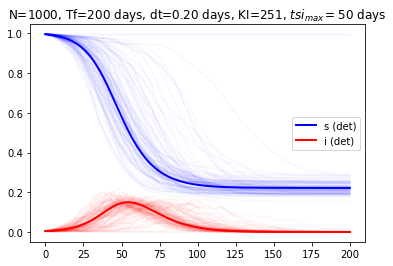

In [12]:
### PLOTS ###
t_list = np.linspace(0,Tf, Nf)

for run in range(total_runs):
    data_agg = data_agg_list[run]
    plt.plot(t_list, data_agg['Sagg'], color='b', alpha=0.03)
    plt.plot(t_list, data_agg['Iagg'], color='r', alpha=0.03)
    
plt.plot(times, s_det_traj, color='b', lw=2, label='s (det)')
plt.plot(times, iagg_det_traj, color='r', lw=2, label='i (det)')
plt.title('N={}, Tf={} days, dt={:1.2f} days, KI={}, $tsi_{{max}}={} $ days'.format(N, Tf, Tf/np.float(Nf), model.parameters['KI'], tsi_max))
plt.legend();